### MAIN NOTEBOOK DE ARMADO DE DATASET PARA SEGMENTACIÓN ÍNTEGRA -> CÁLCULO DE VOLUMEN (después de probar todo lo posible)

In [1]:
import os
import nibabel as nib
import numpy as np
import cv2
import torchio as tio
import matplotlib.pyplot as plt
import SimpleITK as sitk
from PIL import Image
import elasticdeform
from sklearn.model_selection import train_test_split
import shutil
from nyul import nyul_train_standard_scale
from nyul import nyul_apply_standard_scale

### INFO GENERAL DEL DATASET

Hay 6 datasets rejuntados -> total de 116 pacientes -> todas secuencias T2 con sus máscaras anexas en formato .nii <br>
Todo los dataset tienen secuencias mixtas en tamaño de pixel y cantidad de slices. <br>
Además, algunas tienen endorectal coil. <br>
Aclaración: no se realizó ningun registro (centrado en base a imágen madre) ya que el dataset ya viene preprocesado en ese sentido. <br>

#### PREPROCESADO

A priori, se renombraron todos las secuencias y sus máscaras en un formato conveniente. <br>

1. Se realizó un flip de 90° ya que las imágenes viniero rotadas. Además se binarizaron las máscaras ya que algunos datasets tenian multiclase. <br>

2. Se aplicó Bias Correction (N4ITK) a todas las secuencias (incluidas las de TEST ya que se supone parte del preprocesado). <br>

3. Se separaron los 116 pacientes en 10% test (12), del 90% restante (104), 75% train (77), 25% validation (27). <br>
>* Se separó a nivel paciente siguiendo los criterios del "Checklist for Artificial Intelligence in Medical Imaging" (CLAIM). <br>

4. Se normalizaron las secuencias de train y validation utilizando el algoritmo de Nyul. <br>
>* Del entrenamiento de Nyul surgen los landmarks para el preprocesado de futuras secuencias. <br>

5. Se separaron los slices de todas las secuencias en archivos formato .npy. <br>
>* Se recortó el centro de las imágenes llevandolas de 384x384 a 256x256. <br>
>* Se realizó un clipeo usando percentiles 0 y 99.8 del histograma de todo el dataset (menos las de test). <br>
>* Se estandarizaron las imágenes con z-score normalization utilizando la media y desviación estándar de todas las imágenes recortadas (menos las de test). <br>

6. Se realizó Data Augmentation del set de training. <br>
>* Se aplicó Elastic Deformation 2D aleatoriamente al casi 50% (randint) de slices . <br>
>* Se hizo 2D por que 3D generaba artefactos. Además se realizo a la imágen completa, para recortar los defectos de borde. <br>

Al final del split la cantidad de imágenes por set quedó: train: 2665, validation: 826, test: 396 <br>
Con augmentation quedó: train: 3971, validation: 826, test: 396 <br>

---
RENAME

In [ ]:
fp = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\nuevas"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\nuevas2"
allfiles = os.listdir(fp)
allfilesfinales = os.listdir(fp2)
cont = int(len(allfilesfinales)/2)
cont2 = int(len(allfilesfinales)/2)
for file in sorted(allfiles):
    print(file)
    if ("segmentation" in file ) or ("Segmentation" in file): 
        cont+=1
        os.rename(os.path.join(fp,file),os.path.join(fp2,"segmentacion_"+str(cont).zfill(3)+".nii"))
    else:
        cont2+=1
        os.rename(os.path.join(fp,file),os.path.join(fp2,"sujeto_"+str(cont2).zfill(3)+".nii"))


---
FLIP Y BINARIZADO 

In [ ]:
fp = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\nuevas2"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\nuevas"
allfiles = os.listdir(fp)
for file in sorted(allfiles):
    print(file)
    x = nib.load(os.path.join(fp,file))
    img = x.get_fdata()
    img = np.rot90(img,3)
    if "segmentacion" in file: img = np.any(img)
    nifti = nib.Nifti1Image(img, header = x.header, affine= x.affine)
    nib.save(nifti, os.path.join(fp2, file))  

---
BIAS CORRECTION

In [ ]:
fp = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\aa"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\flipped"
allfiles = os.listdir(fp)
for file in sorted(allfiles):
    if "sujeto" in file:
        x = nib.load(os.path.join(fp,file))
        img = x.get_fdata()
        inputImage = sitk.ReadImage(os.path.join(fp,file))
        maskImage = sitk.OtsuThreshold(inputImage,0,1,200)
        inputImage = sitk.Cast(inputImage,sitk.sitkFloat32)
        corrector = sitk.N4BiasFieldCorrectionImageFilter()
        output = corrector.Execute(inputImage,maskImage)
        newimg = np.transpose(sitk.GetArrayViewFromImage(output))
        nifti = nib.Nifti1Image(newimg, header = x.header, affine= x.affine)
        nib.save(nifti, os.path.join(fp2, file))  
    else:
        shutil.copy2(os.path.join(fp,file), os.path.join(fp2,file))

---
SPLIT TRAIN-VALIDATION-TEST

In [3]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\bias_corrected_sec\sujetos"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\bias_corrected_sec\mascaras"
sujetos = os.listdir(fp1)
segmentaciones = os.listdir(fp2)
suj_train,suj_test,seg_train,seg_test = train_test_split(sujetos,segmentaciones,train_size=0.9,random_state=23) #random_state = 23

In [8]:

fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\bias_corrected_sec\sujetos"
fp0 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\bias_corrected_sec\mascaras"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujetos"
fp3 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\test_data\sujetos"
fp4 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\mascaras"
fp5 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\test_data\mascaras"

for file in suj_train:
    shutil.copy2(os.path.join(fp1,file), os.path.join(fp2,file))
for file in suj_test:
    shutil.copy2(os.path.join(fp1,file), os.path.join(fp3,file))
for file in seg_train:
    shutil.copy2(os.path.join(fp0,file), os.path.join(fp4,file))
for file in seg_test:
    shutil.copy2(os.path.join(fp0,file), os.path.join(fp5,file))

In [9]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujetos"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\mascaras"
sujetos = os.listdir(fp1)
segmentaciones = os.listdir(fp2)
suj_train,suj_val,seg_train,seg_val = train_test_split(sujetos,segmentaciones,train_size=0.75,random_state=23) #random_state = 23

In [10]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujetos"
fp0 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\mascaras"
fp3 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data\sujetos"
fp5 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data\mascaras"

for file in suj_val:
    shutil.move(os.path.join(fp1,file), os.path.join(fp3,file))
for file in seg_val:
    shutil.move(os.path.join(fp0,file), os.path.join(fp5,file))

In [ ]:
fp = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\bias_corrected_sec\mascaras"
allfiles = os.listdir(fp)
allz = 0
allnz = 0

for file in allfiles:
    if "segmentacion" in file:
        x = nib.load(os.path.join(fp,file))
        x = x.get_fdata()
        for slice in range(np.size(x,2)):
            if not np.any(x[:,:,slice]): allz+=1
            else: allnz+=1

print(allz,allnz) #2020 1867 -> 48% de máscaras tienen próstata

In [13]:
fp0 = [r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\mascaras",
       r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data\mascaras",
       r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\test_data\mascaras"]
for fp in fp0:
    allfiles = os.listdir(fp)
    allz = 0
    allnz = 0
    for file in allfiles:
        if "segmentacion" in file:
            x = nib.load(os.path.join(fp,file))
            x = x.get_fdata()
            for slice in range(np.size(x,2)):
                if not np.any(x[:,:,slice]): allz+=1
                else: allnz+=1
    print(allz,allnz,allz/(allz+allnz)*100) #cantidad de mascaras SIN prostata / CON prostata / SIN en % -> aprox 50+/-3% (dataset balanceado)

1416 1249 53.13320825515947
416 410 50.363196125908
188 208 47.474747474747474


---
SEPARACION DE SLICES (formato .npy)

Se normalizó y estandarizó el dataset (training).

Primero, se calcularon los landmarks de la normalización de histogramas Nyul para MRI.<br>
El objetivo de Nyul es eliminar las discrepancias en brillo para los mismos tejidos en distintas secuencias debidas a la diferencia de resonadores.<br>
De alguna forma simula una escala similar a la que se encuentra en CT.<br>

In [2]:
standard_path = 'nyul_landmarks.npy'

In [3]:
DATA_DIR = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data"

train_scans = []
for file in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR,file)
    if not os.path.isdir(path):
        if "sujeto" in file:
            train_scans.append(path)

standard_scale, perc = nyul_train_standard_scale(train_scans)

np.save(standard_path, [standard_scale, perc])

processing scan  C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujeto_001.nii
processing scan  C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujeto_002.nii
processing scan  C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujeto_004.nii
processing scan  C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujeto_007.nii
processing scan  C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujeto_008.nii
processing scan  C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujeto_009.nii
processing scan  C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujeto_012.nii
processing scan  C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujeto_013.nii
processing scan  C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujeto_014.nii
processing scan  C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujeto_015.nii
processing scan  C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujeto_016.nii
processing

El siguiente paso es la z-normalization de todo el dataset (training).<br>
Se obtienen la media y desviación estándar del conjunto y luego se aplica individualmente a cada imágen.

In [7]:
fp = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data"
todas = []
for file in os.listdir(fp):
    path = os.path.join(fp,file)
    if not os.path.isdir(path):
        if "sujeto" in file:
            x = nib.load(path)
            x = x.get_fdata()
            x = nyul_apply_standard_scale(x, standard_path)
            for slice in range(np.size(x,2)):
                todas.append(x[63:319,63:319,slice])#(256,256)
ds_hist = np.ravel(todas)

In [9]:
print(ds_hist.shape,np.min(ds_hist),np.max(ds_hist),3*np.std(ds_hist))
p1, p2 = np.percentile(ds_hist,0), np.percentile(ds_hist,99.8)
print(p1,p2)   #-107.75208459640474 128.45794968358558
ds_hist_per = np.clip(ds_hist,p1,p2) #si menor a p1 -> p1, si mayor a p2 -> p2
media, var = np.mean(ds_hist_per), np.std(ds_hist_per) #3.4506247419236113 42.43344987315689
print(media,var)
ds_hist_norm= (ds_hist_per-media)/var
print(np.mean(ds_hist_norm),np.std(ds_hist_norm))

(174653440,) -105.35324697378185 1438.5698506254516 128.5606638621487
-105.35324697378185 127.20468995920034
3.469224631926393 42.501930251698305
5.8424965928392e-16 0.9999999999999982


pruebas sin percentile y clipping

In [20]:
media, var = np.mean(ds_hist), np.std(ds_hist) #3.54715519304951 42.85355462071623
print(media,var)
ds_hist_norm= (ds_hist-media)/var
print(np.mean(ds_hist_norm),np.std(ds_hist_norm))

3.54715519304951 42.85355462071623
-1.9040429020822806e-16 1.000000000000004


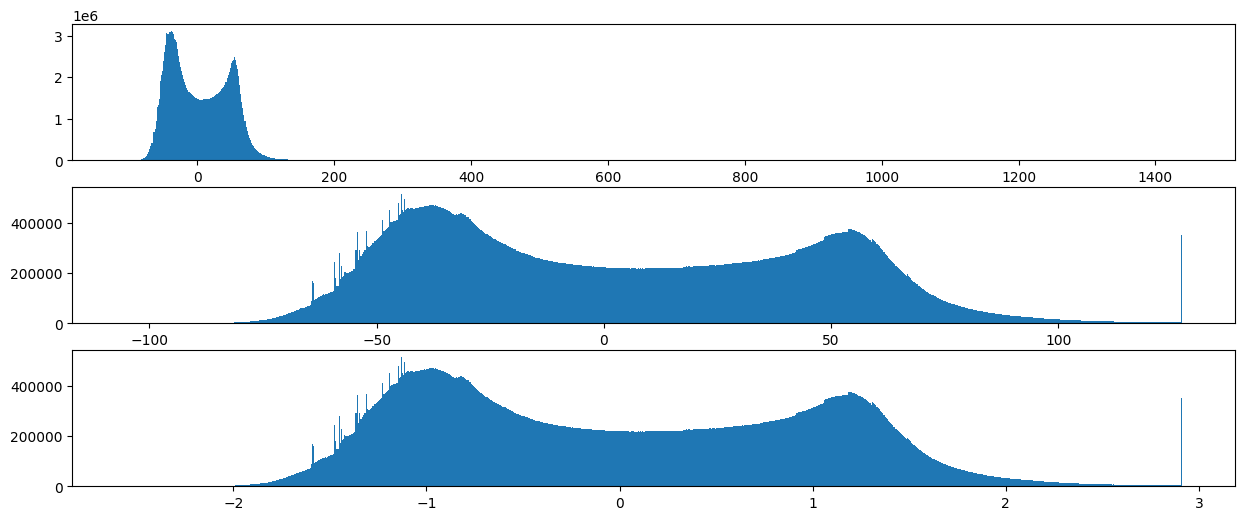

In [10]:
plt.figure(figsize=(15,6))
plt.subplot(3,1,1)
plt.hist(ds_hist,bins=1000)
plt.subplot(3,1,2)
plt.hist(ds_hist_per,bins=1000)
plt.subplot(3,1,3)
plt.hist(ds_hist_norm,bins=1000)
plt.show()

In [11]:
# Un ejemplo de la normalización
fp = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data"
allfiles = os.listdir(fp)
ds_suj = []
for file in allfiles:
    path = os.path.join(fp,file)
    if not os.path.isdir(path):
        if "sujeto" in file:
            ds_suj.append(os.path.join(fp,file))

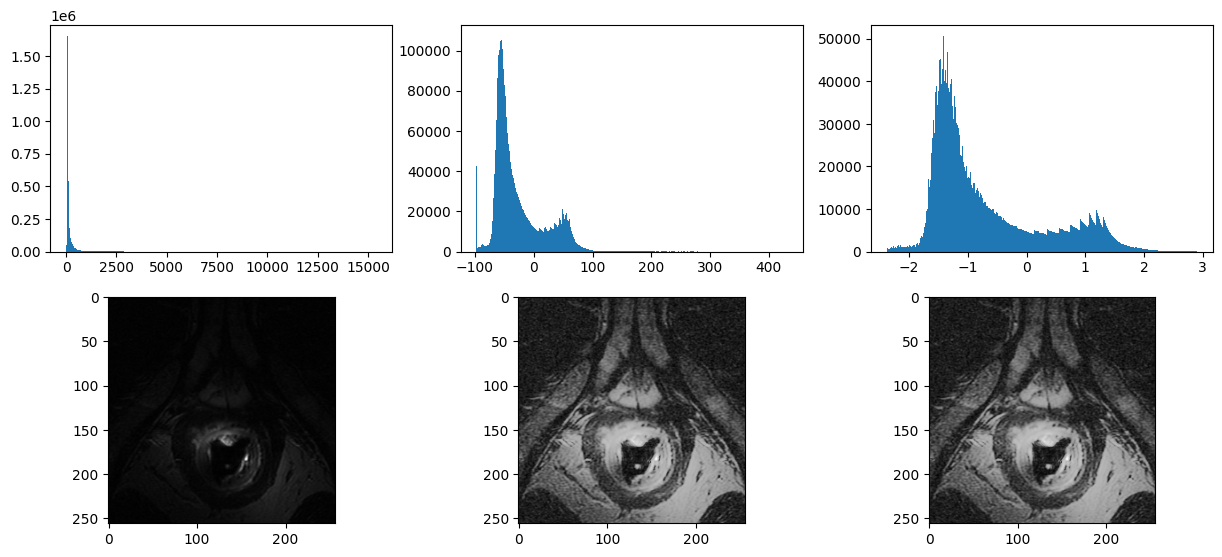

In [18]:
x = nib.load(ds_suj[1])
x = x.get_fdata()
x_nyul = nyul_apply_standard_scale(x, standard_path)
x_norm = np.clip(x_nyul,p1,p2)
x_norm = (x_norm-media)/var

plt.figure(figsize=(15, 10))
plt.subplot(331)
plt.hist(x.flatten(), bins=1000)
plt.subplot(332)
plt.hist(x_nyul.flatten(), bins=1000)
plt.subplot(333)
plt.hist(x_norm.flatten(), bins=1000)
plt.subplot(334)
plt.imshow(x[63:319,63:319,10], cmap='gray')
plt.subplot(335)
plt.imshow(x_nyul[63:319,63:319,10], cmap='gray')
plt.subplot(336)
plt.imshow(x_norm[63:319,63:319,10], cmap='gray')
plt.show()

Creo las slices aplicando Nyul + clip (0-99.8) + z-score normalization. Guardo en formato .npy

In [ ]:
fp0 = [r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\mascaras",
       r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data\mascaras",
       r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\test_data\mascaras",
       r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujetos",
       r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data\sujetos",
       r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\test_data\sujetos"]

In [28]:

fp0 = [r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data",
       r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data",
       r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\test_data"]

In [30]:
for fp in fp0:
    if "train" in fp: name = "train"
    elif "test" in fp: name = "test"
    elif "validation" in fp: name = "val"
    cont = 0
    cont2 = 0

    for file in sorted(os.listdir(fp)):
        path = os.path.join(fp,file)
        if not os.path.isdir(path):
            x = nib.load(path)
            y = x.get_fdata()
            if "sujeto" in file:
                y = nyul_apply_standard_scale(y, standard_path)
                for slices in range(np.size(y,2)):
                    cont+=1
                    img = y[63:319,63:319,slices]
                    #img = np.clip(y[63:319,63:319,slices],p1,p2)
                    img = (img-media)/var                               
                    np.save(fp+"\img_sujeto_"+name+"_"+str(cont).zfill(4),img)
            else:
                for slices in range(np.size(y,2)):
                    cont2+=1
                    img = y[63:319,63:319,slices]
                    np.save(fp+"\img_segmentacion_"+name+"_"+str(cont2).zfill(4),img)    

---

DATA AUGMENTATION

In [7]:
#p1, p2 = -107.75208459640474, 128.45794968358558
#media, var = 3.4506247419236113, 42.43344987315689

In [32]:
fp = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data"
cont = len(os.listdir(fp+"\sujetos"))

for file in sorted(os.listdir(fp)):
    path = os.path.join(fp,file)
    if not os.path.isdir(path):
        if "sujeto_" in file:
            x = nib.load(path)
            y = x.get_fdata()
            y = nyul_apply_standard_scale(y, standard_path)
            for slice in range(np.size(y,2)):
                if np.random.randint(0,100) > 50:
                    a = nib.load(os.path.join(fp,"segmentacion_"+file[-7:]))
                    a = a.get_fdata()
                    cont += 1
                    img_deformed,seg_deformed = elasticdeform.deform_random_grid([y[:,:,slice],a[:,:,slice]], sigma=5, points=10)
                    img = img_deformed[63:319,63:319]
                    #img = np.clip(img_deformed[63:319,63:319],p1,p2)
                    img = (img-media)/var
                    seg = seg_deformed[63:319,63:319]
                    np.save(fp+"\img_sujeto_train_"+str(cont).zfill(4),img)
                    np.save(fp+"\img_segmentacion_train_"+str(cont).zfill(4),seg)        